# Setup importing libraries and modules

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [2]:
try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] Counldn't find going_modular script... Downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning # -f, --force: ignore nonexistent files and arguments, never prompt
  from going_modular.going_modular import data_setup, engine

[INFO] Counldn't find going_modular script... Downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3469 (delta 21), reused 40 (delta 18), pack-reused 3423
Receiving objects: 100% (3469/3469), 642.07 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (1991/1991), done.
Updating files: 100% (222/222), done.


In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Set seeds
def set_seed(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# Prepare data for training model

## Get data

In [5]:
import os
import zipfile
import requests
from pathlib import Path

In [6]:
# Write a function to download data from any source
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  """
  Download a zipped dataset from source and unzips to destination.
  """

  # Setup path to data folder
  data_path = Path('data/')
  image_path = data_path / destination

  # If the image filder doesn't exist, create one
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping downloading.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name # A string representing the final path component, excluding the drive and root
    with open(data_path / target_file, 'wb') as f:
      request = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(request.content)
    
    # Upzip target data
    with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
      print(f"[INFO] Unzipping file...")
      zip_ref.extractall(image_path)

    # Remove .zip file if necessary
    if remove_source:
      os.remove(data_path / target_file)
  
  return image_path

In [7]:
image_path = download_data(
    source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
    destination='pizza_steak_sushi')

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping file...


In [8]:
image_path

PosixPath('data/pizza_steak_sushi')

## Turn data into DataLoader

In [9]:
# Setup train and test directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [10]:
# Create DataLoader with Autotransform
from torchvision import transforms

# Get pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get autotransform besed on the pretrained weights
transform = weights.transforms()

# Create DataLoaders
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f4a257ce520>,
 ['pizza', 'steak', 'sushi'])

# Get a pretrained model

## Download pretrained model

In [11]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Get a summary of the model

In [12]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torchinfo

In [14]:
torchinfo.summary(model=model,
                  input_size=(1, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

## Freeze base layers

In [16]:
# Set the parameters in the feature extraction layers to be not trainable
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
# Check the summary again
torchinfo.summary(model=model,
                  input_size=(1, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

## Modify model classfier

In [18]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [19]:
# Adjust model classifier parameters
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [20]:
# torchinfo.summary(model=model,
#                   input_size=(1, 3, 224, 224),
#                   col_names=["input_size", "output_size", "num_params", "trainable"],
#                   row_settings=['var_names'])

# Setup TensorBoard to track results

In [21]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

# Create a SummaryWriter instance
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

# Train model on custom data

In [22]:
from going_modular.going_modular.engine import train_step, test_step

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [23]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Experiment tracking
        if writer:
          writer.add_scalars(main_tag='Loss', 
                            tag_scalar_dict={'train_loss': train_loss,
                                              'test_loss': test_loss},
                            global_step=epoch)
          
          writer.add_scalars(main_tag='Accuracy',
                            tag_scalar_dict={'train_acc': train_acc,
                                              'test_acc': test_acc},
                            global_step=epoch)
          
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))
          
          # Close the writer
          writer.close()
        else:
          pass

    # Return the filled results at the end of the epochs
    return results

In [24]:
# Set random seed
set_seed()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0941 | train_acc: 0.4531 | test_loss: 0.8689 | test_acc: 0.6600
Epoch: 2 | train_loss: 0.8719 | train_acc: 0.6875 | test_loss: 0.7758 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7636 | train_acc: 0.8359 | test_loss: 0.7484 | test_acc: 0.7330
Epoch: 4 | train_loss: 0.7013 | train_acc: 0.7812 | test_loss: 0.6561 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.6313 | train_acc: 0.7695 | test_loss: 0.6447 | test_acc: 0.8040


# View TensorBoard results

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# Write a function to prepare a SummaryWriter instance

In [26]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """
  Create a torch.utils.tensorboard.writer.SammaryWriter() instance to track results of specified models/experiments.
  """

  from datetime import datetime
  import os

  from torch.utils.tensorboard.writer import SummaryWriter

  # Get timestamp of current point in string
  timestamp = datetime.now().strftime("%Y-%m-%d")

  # Join path
  if extra:
    log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter saving to {log_dir}")

  # Create SummaryWriter() instance
  writer = SummaryWriter(log_dir=log_dir)

  return writer

# Setup a series of modelling experiments

In [27]:
# Download 10% and 20% datasets
data_10_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                                     destination='pizza_steak_sushi')

data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                                     destination='pizza_steak_sushi_20_percent')

[INFO] data/pizza_steak_sushi directory already exists, skipping downloading.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping file...


In [28]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [29]:
# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [30]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [31]:
# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
torchinfo.summary(model=effnetb2, 
                  input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
                  #col_names=["input_size"], # uncomment for smaller output
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
#print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [38]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [39]:
effnetb0 = create_effnetb0() 

# # Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# torchinfo.summary(model=effnetb0, 
#                   input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#                   # col_names=["input_size"], # uncomment for smaller output
#                   col_names=["input_size", "output_size", "num_params", "trainable"],
#                   col_width=20,
#                   row_settings=["var_names"]
# ) 

[INFO] Created new effnetb0 model.


In [40]:
effnetb2 = create_effnetb2()

# # Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# torchinfo.summary(model=effnetb2, 
#                   input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#                   # col_names=["input_size"], # uncomment for smaller output
#                   col_names=["input_size", "output_size", "num_params", "trainable"],
#                   col_width=20,
#                   row_settings=["var_names"]
#) 

[INFO] Created new effnetb2 model.


In [41]:
# Create epoch list
num_epochs = [5, 10]

# Create model list
models = ['effnetb0', 'effbetb2']

# Create a DataLoader distionary
train_dataloaders = {'data_10_percent': train_dataloader_10_percent,
                     'data_20_percent': train_dataloader_20_percent}

In [42]:
%%time
from going_modular.going_modular.utils import save_model

# Set seed
set_seed()

# Keep track of experiment number
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:
      # Print info
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select model and create model
      if model_name == 'effnetb0':
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters())

      # Train target model with target dataloader, epochs, and model
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))
      
      # Save the model to file so we can import it later if needed
      save_filepath = f"{dataloader_name}_{model_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir='models',
                 model_name=save_filepath)
      print(f"-"*80 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-09/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9415 | train_acc: 0.5547 | test_loss: 0.8415 | test_acc: 0.5189
Epoch: 3 | train_loss: 0.8289 | train_acc: 0.6836 | test_loss: 0.7347 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7231 | train_acc: 0.7578 | test_loss: 0.6269 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6034 | train_acc: 0.8906 | test_loss: 0.5957 | test_acc: 0.8759
[INFO] Saving model to: models/data_10_percent_effnetb0_5_epochs.pth
--------------------------------------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effbetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs/2023-03-09/data_10_percent/effbetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9094 | train_acc: 0.6367 | test_loss: 0.9070 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8439 | train_acc: 0.6914 | test_loss: 0.8123 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7193 | train_acc: 0.8477 | test_loss: 0.6987 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7257 | train_acc: 0.7461 | test_loss: 0.6513 | test_acc: 0.8864
[INFO] Saving model to: models/data_10_percent_effbetb2_5_epochs.pth
--------------------------------------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-09/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9415 | train_acc: 0.5547 | test_loss: 0.8415 | test_acc: 0.5189
Epoch: 3 | train_loss: 0.8289 | train_acc: 0.6836 | test_loss: 0.7347 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7231 | train_acc: 0.7578 | test_loss: 0.6269 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6034 | train_acc: 0.8906 | test_loss: 0.5957 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.5488 | train_acc: 0.8711 | test_loss: 0.6081 | test_acc: 0.8258
Epoch: 7 | train_loss: 0.6474 | train_acc: 0.7227 | test_loss: 0.6110 | test_acc: 0.8258
Epoch: 8 | train_loss: 0.5016 | train_acc: 0.9180 | test_loss: 0.5522 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4623 | train_acc: 0.8984 | test_loss: 0.5411 | test_acc: 0.8864
Epoch: 10 | train_loss: 0.5674 | train_acc: 0.7578 | test_loss: 0.4914 | test_acc: 0.8864
[INFO] Saving model to: models/data_10_percent_effnetb0_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9094 | train_acc: 0.6367 | test_loss: 0.9070 | test_acc: 0.6619
Epoch: 3 | train_loss: 0.8439 | train_acc: 0.6914 | test_loss: 0.8123 | test_acc: 0.8153
Epoch: 4 | train_loss: 0.7193 | train_acc: 0.8477 | test_loss: 0.6987 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7257 | train_acc: 0.7461 | test_loss: 0.6513 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.6076 | train_acc: 0.7617 | test_loss: 0.6580 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.5985 | train_acc: 0.8164 | test_loss: 0.6045 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5479 | train_acc: 0.8281 | test_loss: 0.6058 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5176 | train_acc: 0.7891 | test_loss: 0.5704 | test_acc: 0.8466
Epoch: 10 | train_loss: 0.5075 | train_acc: 0.8203 | test_loss: 0.5623 | test_acc: 0.8977
[INFO] Saving model to: models/data_10_percent_effbetb2_10_epochs.pth
---------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7027 | train_acc: 0.7979 | test_loss: 0.5742 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5847 | train_acc: 0.8417 | test_loss: 0.4952 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4565 | train_acc: 0.8938 | test_loss: 0.4133 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4531 | train_acc: 0.8958 | test_loss: 0.3818 | test_acc: 0.9384
[INFO] Saving model to: models/data_20_percent_effnetb0_5_epochs.pth
--------------------------------------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effbetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter saving to runs/2023-03-09/data_20_percent/effbetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7176 | train_acc: 0.8000 | test_loss: 0.6584 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5790 | train_acc: 0.8729 | test_loss: 0.5581 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5314 | train_acc: 0.8354 | test_loss: 0.5132 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4885 | train_acc: 0.8646 | test_loss: 0.4496 | test_acc: 0.9384
[INFO] Saving model to: models/data_20_percent_effbetb2_5_epochs.pth
--------------------------------------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter saving to runs/2023-03-09/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7027 | train_acc: 0.7979 | test_loss: 0.5742 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5847 | train_acc: 0.8417 | test_loss: 0.4952 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4565 | train_acc: 0.8938 | test_loss: 0.4133 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4531 | train_acc: 0.8958 | test_loss: 0.3818 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4222 | train_acc: 0.8604 | test_loss: 0.3730 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3874 | train_acc: 0.8583 | test_loss: 0.3366 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3467 | train_acc: 0.8958 | test_loss: 0.3431 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3729 | train_acc: 0.8896 | test_loss: 0.3395 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3585 | train_acc: 0.8938 | test_loss: 0.2802 | test_acc: 0.9176
[INFO] Saving model to: models/data_20_percent_effnetb0_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7176 | train_acc: 0.8000 | test_loss: 0.6584 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.5790 | train_acc: 0.8729 | test_loss: 0.5581 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5314 | train_acc: 0.8354 | test_loss: 0.5132 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4885 | train_acc: 0.8646 | test_loss: 0.4496 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3798 | train_acc: 0.9167 | test_loss: 0.4660 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3517 | train_acc: 0.9354 | test_loss: 0.4193 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3208 | train_acc: 0.9375 | test_loss: 0.4153 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3426 | train_acc: 0.8875 | test_loss: 0.4336 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3785 | train_acc: 0.8604 | test_loss: 0.3761 | test_acc: 0.9489
[INFO] Saving model to: models/data_20_percent_effbetb2_10_epochs.pth
---------------------------------------

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# Load the best performing model

In [43]:
# Setup nest model path
best_model_path = "/content/models/data_20_percent_effnetb0_10_epochs.pth"

# Tanstantiate a new instance of EffNetB0 to load in the saved state_dict
best_model = create_effnetb0()

# Load in the saved state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

In [44]:
# Check the model file size
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB0 feature extraction model size: {effnetb0_model_size} MB.")

EfficientNetB0 feature extraction model size: 15 MB.


# Make predictions on images and plot them

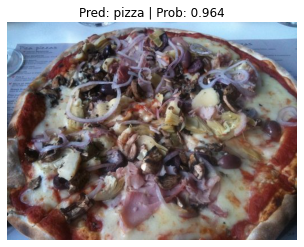

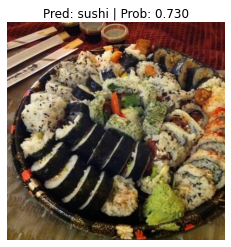

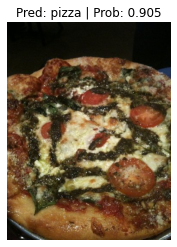

In [45]:
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

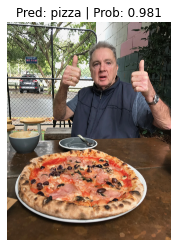

In [46]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)